# Diabetes Prediction Neural Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

print("Diabetes Prediction using Neural Networks")
print("="*40)

Diabetes Prediction using Neural Networks


#### 1. Data loading and preprocessing

In [2]:
# Load dataset
df = pd.read_csv("diabetes.csv")
print(f"📊 Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['Outcome'].value_counts()}")

📊 Dataset shape: (768, 9)
Class distribution:
0    500
1    268
Name: Outcome, dtype: int64


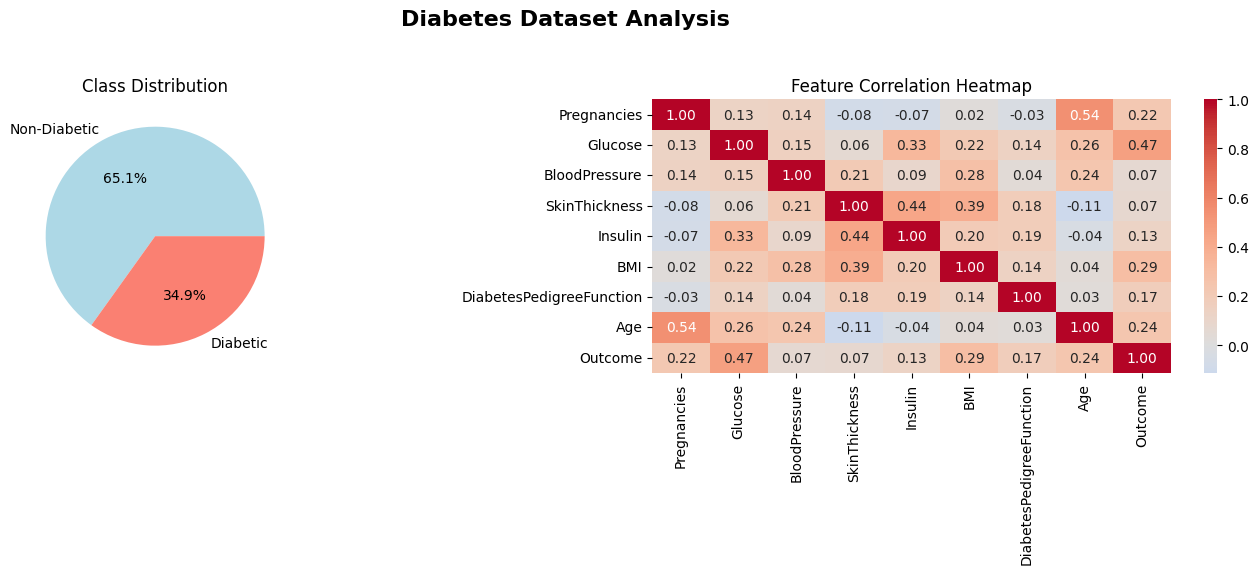

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns
fig.suptitle('Diabetes Dataset Analysis', fontsize=16, fontweight='bold')

# Class distribution (left)
axes[0].pie(df['Outcome'].value_counts(), labels=['Non-Diabetic', 'Diabetic'], 
            autopct='%1.1f%%', colors=['lightblue', 'salmon'])
axes[0].set_title('Class Distribution')

# Correlation heatmap (right)
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, ax=axes[1], fmt='.2f')
axes[1].set_title('Feature Correlation Heatmap')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # adjust layout to fit title
plt.show()


In [4]:
# Handle zero values in specific columns
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    df[col] = df[col].replace(0, df[col].median())

print("✅ Zero values replaced with median")


✅ Zero values replaced with median


In [5]:
# Split features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Train/Validation/Test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"📊 Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

📊 Data split - Train: 537, Val: 115, Test: 116


#### 2. Model architecture and training

In [7]:
def plot_individual_training_curves(history, model_name):
    """Plot training curves for individual model"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze overfitting/underfitting
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc
    
    print(f"📈 Training Analysis for {model_name}:")
    print(f"   Final Training Accuracy: {final_train_acc:.4f}")
    print(f"   Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"   Gap: {gap:.4f}")
    
    if gap > 0.1:
        print("   ⚠️ Potential overfitting detected")
    elif gap < 0.02:
        print("   ✅ Good generalization - Well balanced model")
    else:
        print("   👍 Acceptable generalization")


🔹 Training Baseline Model


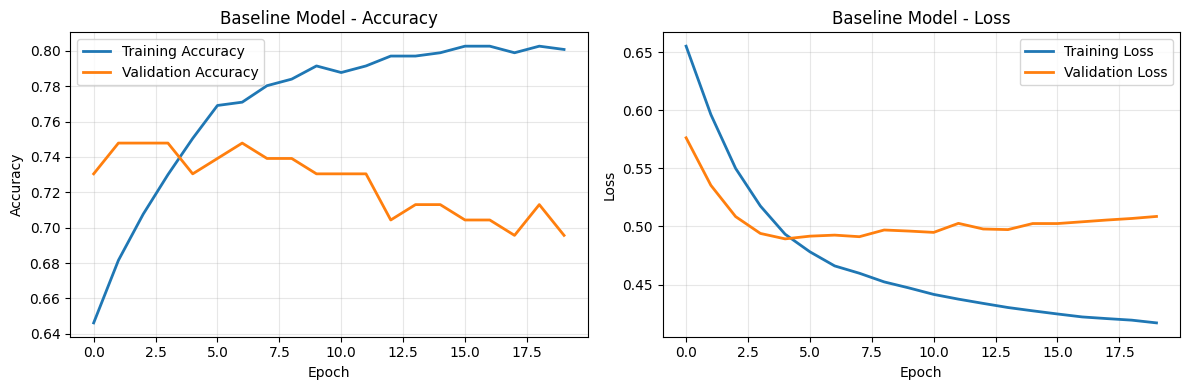

📈 Training Analysis for Baseline Model:
   Final Training Accuracy: 0.8007
   Final Validation Accuracy: 0.6957
   Gap: 0.1051
   ⚠️ Potential overfitting detected


In [8]:
# Model 1: Baseline Model (Simple architecture)
def create_baseline_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(8,)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("\n🔹 Training Baseline Model")
baseline_model = create_baseline_model()
baseline_callbacks = [EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]

baseline_history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=baseline_callbacks,
    verbose=0
)

plot_individual_training_curves(baseline_history, "Baseline Model")


🔸 Training Regularized Model


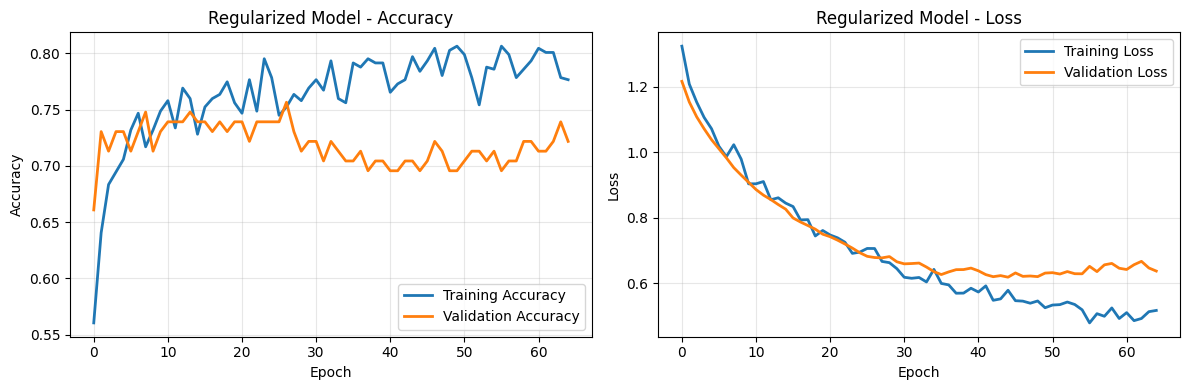

📈 Training Analysis for Regularized Model:
   Final Training Accuracy: 0.7765
   Final Validation Accuracy: 0.7217
   Gap: 0.0548
   👍 Acceptable generalization
🔸 Regularized model uses Dropout to prevent overfitting
🔸 EarlyStopping prevents overtraining and saves computation time


In [9]:
# Model 2: Regularized Model (With Dropout and BatchNormalization)
def create_regularized_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(8,), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),  # Dropout to prevent overfitting
        
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(16, activation='relu'),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("\n🔸 Training Regularized Model")
regularized_model = create_regularized_model()
regularized_callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('best_regularized_model.h5', monitor='val_accuracy', save_best_only=True)
]

regularized_history = regularized_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=regularized_callbacks,
    verbose=0
)

plot_individual_training_curves(regularized_history, "Regularized Model")
print("🔸 Regularized model uses Dropout to prevent overfitting")
print("🔸 EarlyStopping prevents overtraining and saves computation time")


🔷 Training Deep Model


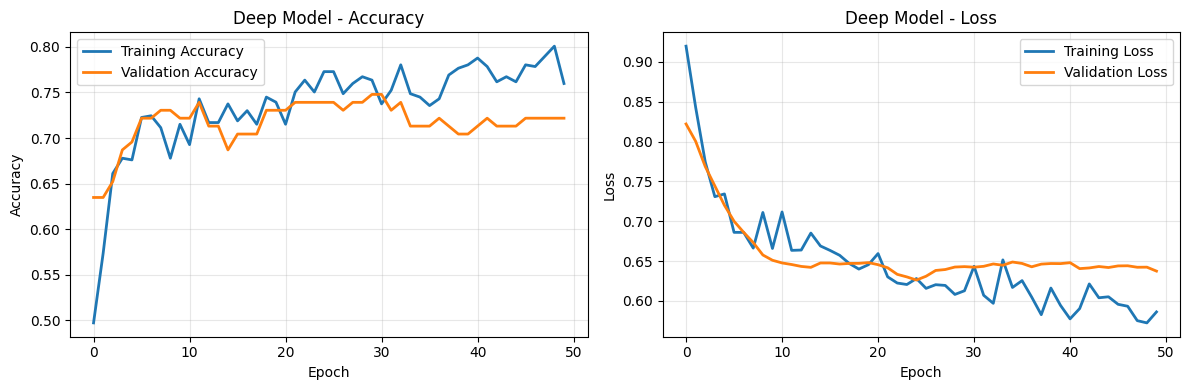

📈 Training Analysis for Deep Model:
   Final Training Accuracy: 0.7598
   Final Validation Accuracy: 0.7217
   Gap: 0.0380
   👍 Acceptable generalization


In [10]:
# Model 3: Deep Model
def create_deep_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(8,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("\n🔷 Training Deep Model")
deep_model = create_deep_model()
deep_callbacks = [EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)]

deep_history = deep_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=16,
    callbacks=deep_callbacks,
    verbose=0
)

plot_individual_training_curves(deep_history, "Deep Model")


#### 3. Hyperparameter tuning using Grid Search

In [11]:
print("\n🔍 Performing Grid Search for Hyperparameter Tuning")

def create_tunable_model(units=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Dense(units, activation='relu', input_shape=(8,), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(units//2, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Parameter grid
param_grid = {
    'model__units': [32, 64, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__learning_rate': [0.001, 0.01],
    'epochs': [50],
    'batch_size': [16, 32]
}

# Create KerasClassifier wrapper
keras_classifier = KerasClassifier(
    model=create_tunable_model,
    verbose=0
)

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=keras_classifier,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

print("Running Grid Search...")
grid_result = grid_search.fit(X_train, y_train)

print("\n🏆 Grid Search Results:")
print(f"Best Score: {grid_result.best_score_:.4f}")
print("Best Parameters:")
for param, value in grid_result.best_params_.items():
    print(f"  {param}: {value}")


🔍 Performing Grid Search for Hyperparameter Tuning
Running Grid Search...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

🏆 Grid Search Results:
Best Score: 0.7709
Best Parameters:
  batch_size: 32
  epochs: 50
  model__dropout_rate: 0.4
  model__learning_rate: 0.001
  model__units: 32


##### Model Comparison Summary & Best Model Selection

As of now, we've evaluated four models:

- **Baseline Model**  
  - Validation Accuracy: **0.6957**

- **Regularized Model**  
  - Validation Accuracy: **0.7217**

- **Deep Model**  
  - Validation Accuracy: **0.7217**

- **Tunable Model (via Grid Search)**  
  - Cross-Validated Accuracy: **0.7709**  
  - This score is obtained using 3-fold cross-validation on the training set and reflects strong generalization performance.

---
✅ So far, we tested four models: the Baseline model (validation accuracy: 0.6957), Regularized model (0.7217), Deep model (0.7217), and a Tunable model using Grid Search, which achieved the highest cross-validated accuracy of 0.7709. Since it performs best in terms of generalization, the Tunable model is selected as the best model for now.



#### 4. Final model training and saving

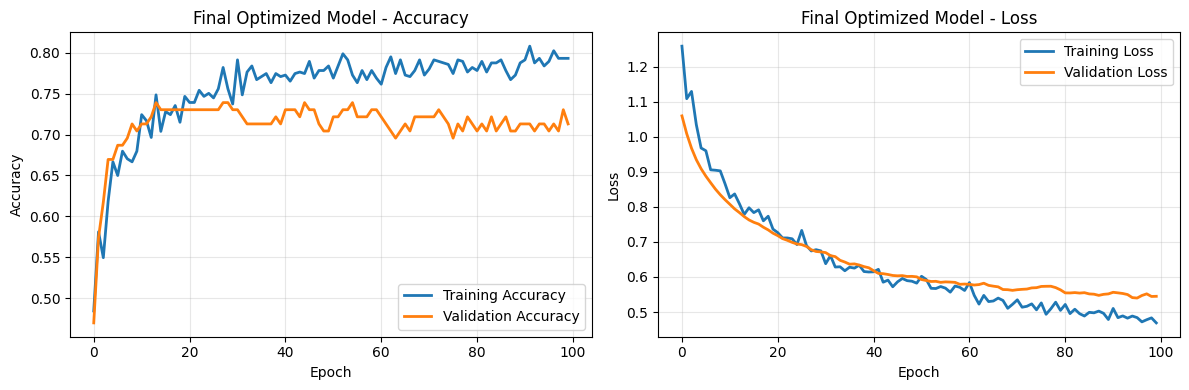

📈 Training Analysis for Final Optimized Model:
   Final Training Accuracy: 0.7933
   Final Validation Accuracy: 0.7130
   Gap: 0.0803
   👍 Acceptable generalization
✅ Model saved to 'final_model_1.h5'
✅ Scaler saved to 'scaler_1.pkl'


In [12]:
# Create final model with best parameters
final_model = create_tunable_model(
    units=grid_result.best_params_['model__units'],
    dropout_rate=grid_result.best_params_['model__dropout_rate'],
    learning_rate=grid_result.best_params_['model__learning_rate']
)

final_callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('final_model.h5', monitor='val_accuracy', save_best_only=True)
]

final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=grid_result.best_params_['batch_size'],
    callbacks=final_callbacks,
    verbose=0
)

# Plot final model training curves
plot_individual_training_curves(final_history, "Final Optimized Model")

# Save model and scaler
final_model.save('final_model_1.h5')
joblib.dump(scaler, 'scaler_1.pkl')
print("✅ Model saved to 'final_model_1.h5'")
print("✅ Scaler saved to 'scaler_1.pkl'")


We observed overfitting in final tuned model also (Train acc: 0.79 vs Val acc: 0.71). Need to fine-tune manually further.

In [14]:
def create_final_model(units=64, dropout_rate=0.4, learning_rate=0.001, l2_strength=0.02):
    model = Sequential([
        Dense(units, activation='relu', input_shape=(8,), kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(units // 2, activation='relu', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

param_grid = {
    'model__units': [32, 64],
    'model__dropout_rate': [0.3, 0.4, 0.5],
    'model__learning_rate': [0.001],
    'epochs': [100],
    'batch_size': [16],
}

keras_classifier = KerasClassifier(
    model=create_final_model,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=keras_classifier,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1
)

grid_result = grid_search.fit(X_train, y_train)

print("✅ Grid Search Done.")
print(f"Best Validation Accuracy (CV): {grid_result.best_score_:.4f}")
print("Best Parameters:")
print(grid_result.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Grid Search Done.
Best Validation Accuracy (CV): 0.7709
Best Parameters:
{'batch_size': 16, 'epochs': 100, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__units': 32}


In [15]:
best_params = grid_result.best_params_

final_model = create_final_model(
    units=best_params['model__units'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

final_callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('final_model.h5', monitor='val_accuracy', save_best_only=True)
]

final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=final_callbacks,
    verbose=0
)


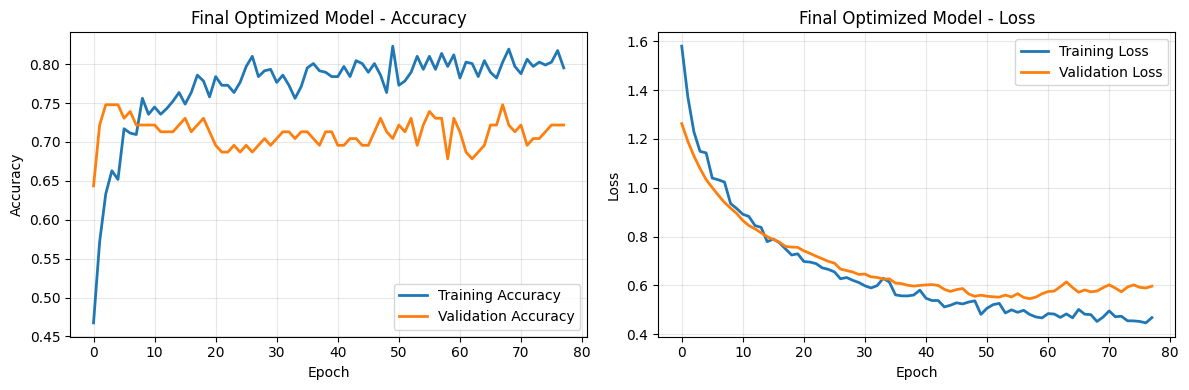

📈 Training Analysis for Final Optimized Model:
   Final Training Accuracy: 0.7952
   Final Validation Accuracy: 0.7217
   Gap: 0.0734
   👍 Acceptable generalization


In [16]:
# Plot final model training curves
plot_individual_training_curves(final_history, "Final Optimized Model")

In [17]:
# Save model and scaler
final_model.save('final_model_2.h5')
joblib.dump(scaler, 'scaler_2.pkl')
print("✅ Model saved to 'final_model_2.h5'")
print("✅ Scaler saved to 'scaler_2.pkl'")

✅ Model saved to 'final_model.h5'
✅ Scaler saved to 'scaler.pkl'


#### 5. Model testing

In [21]:
print("\nFinal Evaluation on Test Set")

# Load the saved model
loaded_model = load_model('final_model_2.h5')
loaded_scaler = joblib.load('scaler.pkl')
print("Model and scaler loaded successfully")

# Predict on test set
test_predictions_prob = loaded_model.predict(X_test)
test_predictions = (test_predictions_prob > 0.5).astype(int)

# Calculate all metrics
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
test_auc = roc_auc_score(y_test, test_predictions_prob)

print("\n🧠 Interpretation of Results:")
print(f"📈 Accuracy:  {test_accuracy:.4f} ({test_accuracy:.1%})")
print(f"🎯 Precision: {test_precision:.4f} ({test_precision:.1%})")
print(f"📡 Recall:    {test_recall:.4f} ({test_recall:.1%})")
print(f"⚖️ F1-Score:  {test_f1:.4f} ({test_f1:.1%})")
print(f"🎪 ROC-AUC:   {test_auc:.4f} ({test_auc:.1%})")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, test_predictions, target_names=['Non-Diabetic', 'Diabetic']))



Final Evaluation on Test Set
Model and scaler loaded successfully
4/4 [==============================] - 0s 3ms/step

🧠 Interpretation of Results:
📈 Accuracy:  0.7328 (73.3%)
🎯 Precision: 0.6667 (66.7%)
📡 Recall:    0.4878 (48.8%)
⚖️ F1-Score:  0.5634 (56.3%)
🎪 ROC-AUC:   0.8485 (84.8%)

Detailed Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.76      0.87      0.81        75
    Diabetic       0.67      0.49      0.56        41

    accuracy                           0.73       116
   macro avg       0.71      0.68      0.69       116
weighted avg       0.72      0.73      0.72       116



#### 6. Final visualization

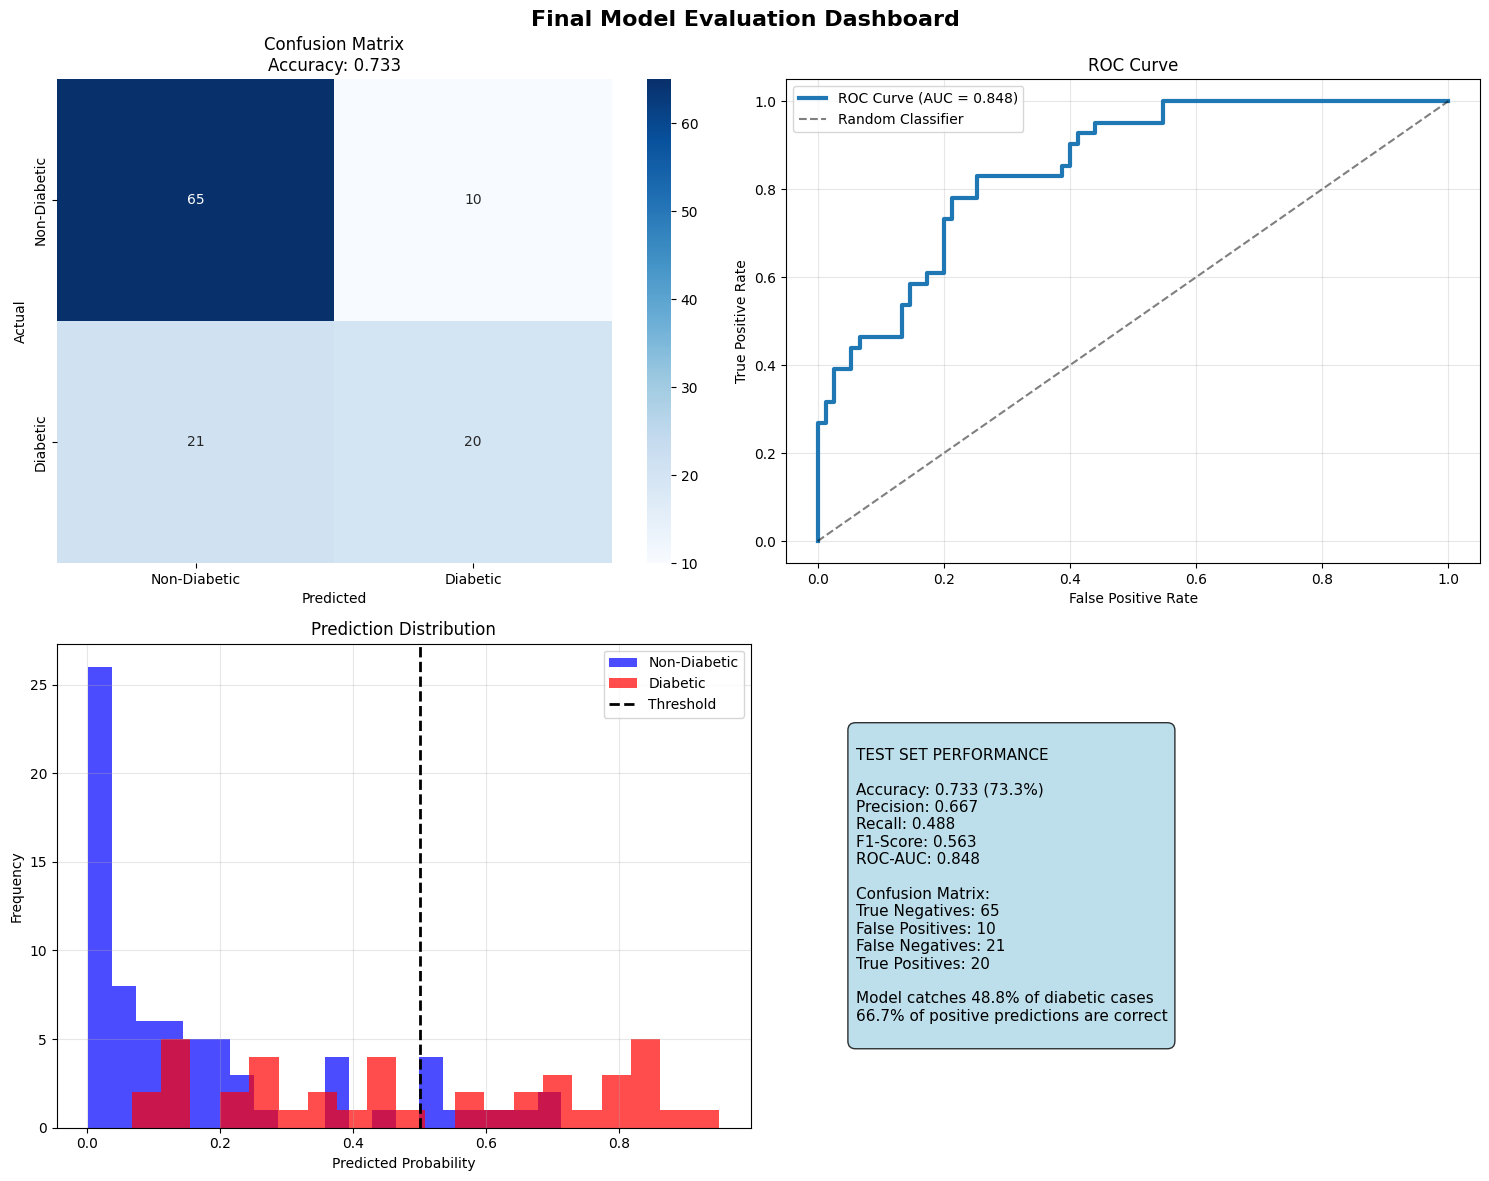

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Final Model Evaluation Dashboard', fontsize=16, fontweight='bold')

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
axes[0,0].set_title(f'Confusion Matrix\nAccuracy: {test_accuracy:.3f}')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_predictions_prob)
axes[0,1].plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {test_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Prediction Distribution
axes[1,0].hist(test_predictions_prob[y_test == 0], bins=20, alpha=0.7, 
               label='Non-Diabetic', color='blue')
axes[1,0].hist(test_predictions_prob[y_test == 1], bins=20, alpha=0.7, 
               label='Diabetic', color='red')
axes[1,0].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Prediction Distribution')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Performance Summary
axes[1,1].axis('off')
tn, fp, fn, tp = cm.ravel()

performance_text = f"""
TEST SET PERFORMANCE

Accuracy: {test_accuracy:.3f} ({test_accuracy:.1%})
Precision: {test_precision:.3f}
Recall: {test_recall:.3f}
F1-Score: {test_f1:.3f}
ROC-AUC: {test_auc:.3f}

Confusion Matrix:
True Negatives: {tn}
False Positives: {fp}
False Negatives: {fn}
True Positives: {tp}

Model catches {test_recall:.1%} of diabetic cases
{test_precision:.1%} of positive predictions are correct
"""

axes[1,1].text(0.1, 0.5, performance_text, fontsize=11, verticalalignment='center',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.show()


### ✅ Conclusion

- The final tuned model achieved **73% accuracy** and **0.84 ROC AUC** on the test set.
